In [1]:
import string
import copy
import scipy
import Tkinter, tkFileDialog
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import os
import re
import sys
import cPickle
import glob
from PIL import Image, ImageDraw, ImageColor
sys.path.append(os.path.abspath("C:\Users\Scherer Lab E\Documents\GitHub\Python_Data_Analysis"))
import half_nanoplate_functions as hnf
import common_functions
%matplotlib inline

C:\Users\Scherer Lab E\Anaconda2\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


## Import the data

In [2]:
'''Import the Original Half Nanoplate Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list = glob.glob('Mov_012014*linked.pandas')
data_list = [pd.read_pickle(i) for i in file_list]

In [3]:
'''Import Uncut Original Half Nanoplate Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list_uncut = glob.glob('Mov_012014*pre-linking.mat')
data_list_uncut = [common_functions.import_matlab_gui(i) for i in file_list_uncut]
data_list_uncut = [common_functions.matlab_gui_to_data_frame(i) for i in data_list_uncut]

Loading Mov_01201403_pre-linking.mat
Loading Mov_01201404_pre-linking.mat
Loading Mov_01201405_pre-linking.mat
Loading Mov_01201406_pre-linking.mat
Loading Mov_01201407_pre-linking.mat
Loading Mov_01201408_pre-linking.mat


In [4]:
'''Import the Matlab Gui Data'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list_proc = glob.glob('Mov_012014*pre-linking_processed_2.mat')
data_list_proc = [common_functions.import_matlab_gui(i) for i in file_list_proc]
data_list_proc = [hnf.matlab_gui_to_data_frame_with_intesity(i) for i in data_list_proc]

Loading Mov_01201403_pre-linking_processed_2.mat
Loading Mov_01201404_pre-linking_processed_2.mat
Loading Mov_01201405_pre-linking_processed_2.mat
Loading Mov_01201406_pre-linking_processed_2.mat
Loading Mov_01201407_pre-linking_processed_2.mat
Loading Mov_01201408_pre-linking_processed_2.mat


## Eliminate Spurious Particles Over Nanoplate and Near Boundary

Find where extra particles are being created by the halo around particles when they are over the nanoplate. First need to define when particles are over the nanoplate. For the boundary of particles going up onto the nanoplate 97 degrees was selected as being the cutoff. For particles leaving the plate we want to find the minimum of the distribution of positions around that location. A histogram can leave several minima and some confusion as to which one is the actual minimum. To mitigate this issue a gaussian kernel density estimator was used to predict the distribution. The minimum of this KDE was selected as the cutoff. 

(Note: This is different than how it was done previously on the half nanoplate data. Before a polygon was selected by hand and if positions were contained within the polygon then they would be considered over the nanoplate. This has the advantage that I am more directly using the 2 dimensions of the image data to select these particles. However, we ultimately care about the particle motion along the reaction coordinate [theta] which is why the KDE method was chosen.)

In [5]:
'''Do y-flip of position data and add polar coordinates'''
transformed_data_list_proc = []
for df in data_list_proc:
    new_flip = common_functions.y_axis_flip(df, 390)
    temp_fit_params = common_functions.least_sq_fit_circle(new_flip)
    common_functions.polar_coor_data_frame(new_flip, temp_fit_params[0], temp_fit_params[1])
    transformed_data_list_proc.append(new_flip)

### Label Particles Over Plate

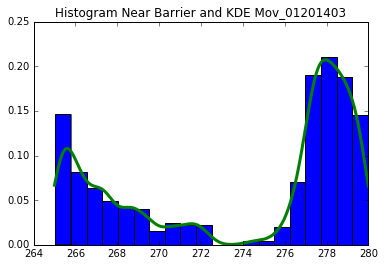

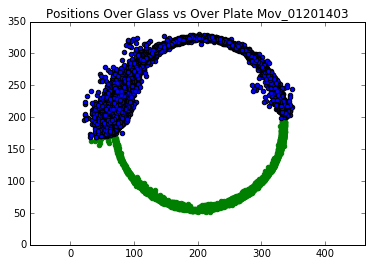

Barrier minimum 273.421052632


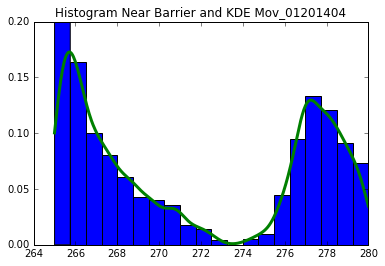

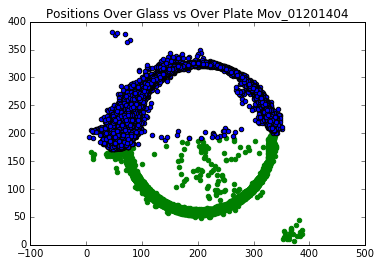

Barrier minimum 273.496240602


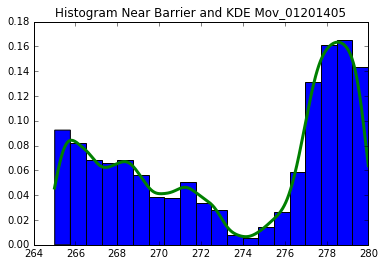

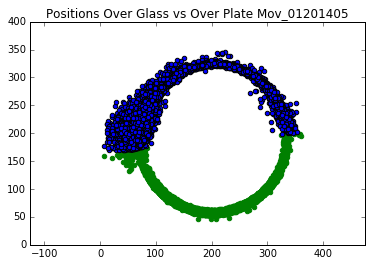

Barrier minimum 274.135338346


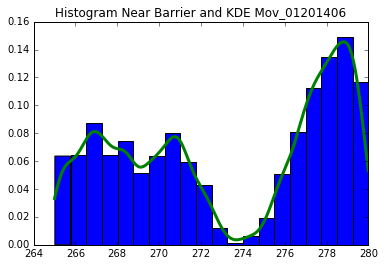

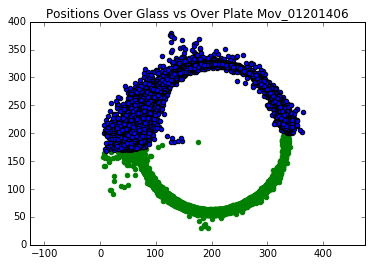

Barrier minimum 273.684210526


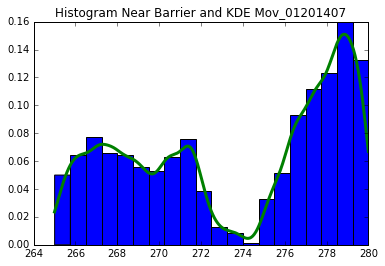

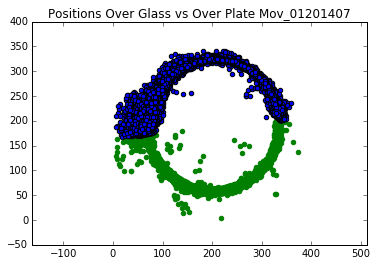

Barrier minimum 274.248120301


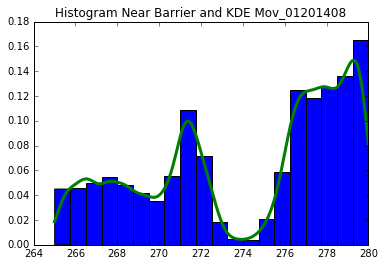

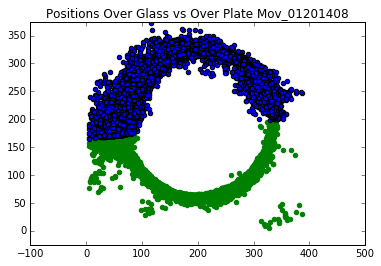

Barrier minimum 273.947368421


In [6]:
barrier_minima = []
for num, df in enumerate(transformed_data_list_proc):
    # Show theta histogram
    plt.hist(df.query('265 < theta < 280')['theta'], bins=20, normed=True)
    theta = np.linspace(265,280,400)
    
    # Generate the gaussian KDE
    kernel = scipy.stats.gaussian_kde(df.query('265 < theta < 280')['theta'], bw_method=0.08)
    plt.plot(theta, kernel.evaluate(theta), lw=3)
    plt.title("Histogram Near Barrier and KDE "+file_list_proc[num][:12])
    plt.show()
    
    # Label positions in the DataFrame
    barrier = theta[np.argmin(kernel.evaluate(theta))]
    barrier_minima.append(theta[np.argmin(kernel.evaluate(theta))])
    over_plate_particles = (df.theta > 97) & (df.theta < barrier) 
    df.loc[over_plate_particles, 'over_plate'] = True
    df.loc[~over_plate_particles, 'over_plate'] = False
    
    # Show which positions are over plate
    plt.scatter(df[over_plate_particles]['x pos'], df[over_plate_particles]['y pos'], color='g')
    plt.scatter(df[~over_plate_particles]['x pos'], df[~over_plate_particles]['y pos'])
    plt.axis('equal')
    plt.title("Positions Over Glass vs Over Plate "+file_list_proc[num][:12])
    plt.show()
    
    print "Barrier minimum "+str(theta[np.argmin(kernel.evaluate(theta))])

### Eliminate Spurious Particles Over Plate

### Filter Close Particles Over Plate

Particles imaged over the nanoplate mirror are out of focus compared to the particles over the glass. The out of focus image of a nanoparticle over the nanoplate has a halo around the high intensity center of the particle. When particle tracking is performed on the processed data, the parameters for selecting local maxima for particle identification had to be sensitive to the weak signal of particles near the nanoplate boundary, however using these settings causes the particle tracker to pick up the halos around the particles over the plate as additional particles.

In order to get clean trajectories spurious particles found over the nanoplate due to this out of focus halo effect were removed. The method of removing particles was for each particle over the nanoplate find all other particles within some maximum distance l (in pixels). Amongst a group of particles found withing l, only the particle with the highest integrated intensity is chosen as the true particle, all other particles are removed.

In [7]:
def find_k_nn(grp, num_nn_k=None):
    '''This function will find the k nearest neighbors in x-y and add 
    columns to the data frame that include the nn number (1st, 2nd,...), the
    particle id of the nn, and the distance of that nn.
    The way to use this function is as such:
    
    df.groupby('frame',group_keys=False).apply(find_k_nn, num_nn_k=X)
    
    The group_keys kwarg prevents a redundant frames column. Reseting the index
    will give the data frame a regular integer index like before the function
    is applied. The second line rearranges the columns to the correct order.
    '''
    xy_data = grp[['x pos','y pos']]
    tree = scipy.spatial.KDTree(xy_data)
    if num_nn_k == None:
        num_nn_k = len(xy_data)
    elif num_nn_k > len(xy_data)-1:
        num_nn_k = len(xy_data)
    elif num_nn_k != None:
        num_nn_k += 1
    nn_d, nn_i = tree.query(xy_data, k=num_nn_k)
    if len(nn_d)==1: # If only one particle return the group
        grp['nn_num'] = np.nan
        grp['nn_id'] = np.nan
        grp['nn_dist'] = np.nan
        return grp
    particle_ids = grp['particle id'].values
    track_ids = np.tile(particle_ids, (num_nn_k,1))
    track_ids = track_ids.T[:,1:].flatten()
    nn_ids = particle_ids[nn_i][:,1:].flatten()
    nn_dist = nn_d[:,1:].flatten()
    # Create nn number column (1st, 2nd, etc)
    nn_num = np.arange(len(nn_d[0]))
    nn_num = np.tile(nn_num,(len(particle_ids),1))[:,1:]
    nn_num = nn_num.flatten()
    # Merge with current group
    nn_df = pd.DataFrame(np.vstack((track_ids, nn_num, nn_ids, nn_dist)).T, columns=['particle id','nn_num','nn_id','nn_dist'])
    new_df = pd.merge(grp, nn_df, left_on='particle id', right_on='particle id')
    return new_df

def sorted_id_string(series):
    '''A helper function for filter_close_false_particles_over_plate
    that will give each pair of NN a unique string (the same string) to
    identify them. '''
    #pdb.set_trace()
    particle_series = pd.concat((series['particle id'], series.nn_id))
    particle_series = particle_series.drop_duplicates()
    particle_list = sorted(list(particle_series))
    #particle_series.sort_values()
    
#     particle_list = [series['particle id'].values, series.nn_id.values]
    
#     particle_list = sorted(particle_list)
    #print particle_list
    string_list = [str(int(i)) for i in particle_list]
    string = ''
    for num, part_id in enumerate(string_list):
        if num == 0:
            string += part_id
        else:
            string += '+'+part_id
    return string

def bad_frame_particle_pairs(grp):
    max_intensity = grp.intensity.max()
    grp_to_drop = grp[~(grp.intensity == max_intensity)]
    return grp_to_drop[['frame', 'particle id']].drop_duplicates()

def filter_close_false_particles_over_plate_intensity(data_frame, max_nn_dist, angle_bounds=(0,360), nn_num=1):
    '''This function filters out false particles due to halo effect around 
    particles over the nanoplate with a preference of keeping particles with higher
    integrated intensity.
    
    The identification of the Half Nanoplate data produce several false particles
    due to a halo around the particles over the nanoplate. Usually these false
    particles appear less than one particle diameter from the real one. Removing
    them will give more consistent trajectories for the tracking. The real 
    particles are assumed to be the ones with a higher integrated intensity and
    also within some NN distance around one particle diameter.
    
    :param data_frame: The data_frame that contains the particle xy data and has
    particles over the nanoplate labeled
    :param max_nn_dist: The maximum distance two particles will be flagged with one
    potentially being false. Should be set to be about the particle diameter.
    :param angle_bounds: If you want to limit the search for false particles to
    a particular angle range (beyond just checking over the nanoplate) this can
    be set.
    :param nn_num: The number of nearest neighbors to account for when determining 
    which particles to get rid of.
    '''
    over_plate_particles = data_frame[data_frame.over_plate == True].copy()
    lower_angle = angle_bounds[0]
    upper_angle = angle_bounds[1]
    valid_particles = over_plate_particles.query('@lower_angle < theta < @upper_angle')
    # Find first NN of all particles in all frames (over nanoplate)
    df_nn = valid_particles.groupby('frame', group_keys=False).apply(find_k_nn, num_nn_k=nn_num+1)
    r_mean = df_nn.r.mean()
    # Find particles with less than nn_dist separation
    #print df_nn
    particles_within_bounds = df_nn[df_nn.nn_dist < max_nn_dist].copy()
    particles_within_bounds['del_r'] = particles_within_bounds['r']-r_mean
    paired_df = particles_within_bounds.groupby(['frame','particle id'], group_keys=False).apply(lambda x: x.assign(pair = sorted_id_string(x)))
    bad_indices = paired_df.groupby(['frame','pair']).apply(bad_frame_particle_pairs)
    data_frame_reindex = data_frame.set_index(['frame', 'particle id'], drop=True)
    data_frame_dropped = data_frame_reindex.drop(tuple(bad_indices.values[i,:]) for i in range(len(bad_indices.values[:,0])))
    return data_frame_dropped.reset_index()

In [8]:
'''Eliminate double particles that appear over Nanoplate surface'''
cleaned_up_particles = []
for idx, v in enumerate(transformed_data_list_proc):
    cleaned_up_particles.append(filter_close_false_particles_over_plate_intensity(v, 12, nn_num=9))

The problem with the way I coded the method to eliminate the spurious particles over the nanoplate is that there is an assumption that all nearest neighbors are within the max nearest neighbor distance set. The algorithm was designed to work with particle pairs. The problem comes when the "pair" string is created when there is more than 2 particles present. The example below shows the problem

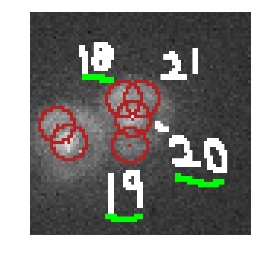

In [9]:
image_path = "C:\Users\Scherer Lab E\Documents\IPython Notebooks\Half Nanoplate Analysis\Data\Figures for Notebooks\\16053001 Example breaking spurious particles over plate.PNG"
im = plt.imread(fname=image_path)
plt.axis('off')
plt.imshow(im)

A string is created based on nearby particles to make it easy to index particles by groups. This string is entered into the DataFrame as the value "pair". In the image above particle 20 sees all other particles so its "pair" value is "18+19+20+21". Particle 18 and 21 doesn't see particle 19 so their "pair" strings are "18+20+21". A groupby operation is called on the "pair" column selecting all particles that have the same "pair" string. For each "pair" group the particle with the maximum intesity is kept and all other particles are dropped. Becuase only exact values of "pair" are grouped together this prevents you to select the particle of maximum intensity for the whole group of particles. Particle 20 is the only particle with a "pair" value of "18+19+20+21" creating a group with just particle 20. Therefore particle 20 has the max intensity in that group and is kept while all other particles (which there are none) are dropped. However particle 18 and particle 21 share the "pair" value of "18+20+21". Of that group of two particles (particle 18 and 21), particle 18 has the higher intensity so particle 21 is dropped. Because of similar consequences of creating these "pair" values, particle 19 is kept because it is the only particle with the "pair" value of "19+20". The final result is particles 18, 19, and 20 are kept and particle 21 is eliminated. 

The correct way to solve this is to search recursively each of the nearest neighbors and create network of particles that are all within the max distance parameter. This should build a "pair" value of "18+19+20+21" for particle 18, 19, 20, and 21. Then particle 20 would be selected as the one of maximum intensity.

I didn't want to spend the time to develop such an algorithm and I was also worried about two (real) particles get close enough that it would eliminate real particles. Instead I opted to remove particles by hand. I would comb through the images and record rough positions of the particles I want eliminated in addition to which frame they are in and I wrote a function that finds the particle closest to that location to eliminate. In the example above I would record the position (within 3 pixel accuracy) of the x and y positions of particle 18 and 19 and my function will cut those positions from the DataFrame

In [10]:
'''Deal with missed extra particles over the nanoplate'''

frames_extra_particles = [[],
                         [],
                         [553, 741, 1039, 1173, 1501, 1503, 1638, 1958, 1737],
                         [137, 397, 400, 586, 992, 1007, 1636, 1638, 1867, 1868, 1965],
                         [32, 33, 278, 777, 798, 1538, 1715, 1722],
                         []]

xy_positions_extra_particles = [[],
                              [],
                              [[261, 313],[263,329],[274,312],[267,327],[198,334],[195,329],[174,328],[176,334],[272,307],[276,322],[303,290],[304,275],[231,341],[230,326],[326,182], [292,290], [304,294], [304,278]],
                              [[322,269],[319,255],[177,327],[275,306],[287,312],[287,312],[279,302],[309,286],[297,282],[309,271],[280,315],[267,308],[251,318],[254,331],[297,304],[286,310],[287,296],[307,290],[298,284],[309,290]],
                              [[287,308],[275,302],[314,261],[325,265],[311,269],[300,281],[301,286],[297,303],[271,318],[259,312],[298,301],[267,324],[261,309],[237,322]],
                              []]

num_extra_particles = [[],
                      [],
                      [2,2,2,2,2,2,2,1,3],
                      [2,1,2,2,3,2,2,1,2,1,2],
                      [2,2,2,2,2,1,2,1],
                      []]

def drop_particle_frame_and_position(df, frame, xy_position, radius=2):
    '''Looks for a particle in a specific frame near a specific position
    and returns the data frame with that particle dropped.'''
    particle_df = df[df.frame == frame]
    x_cent = xy_position[0]
    y_cent = xy_position[1]
    x_selection = (particle_df['x pos'] > x_cent - radius) & (particle_df['x pos'] < x_cent + radius)
    y_selection = (particle_df['y pos'] > y_cent - radius) & (particle_df['y pos'] < y_cent + radius)
    indices_to_drop = particle_df[x_selection & y_selection].index
    return df.drop(indices_to_drop)
    

extra_particles_cleaned_up = []
for idx, df in enumerate(cleaned_up_particles):
    frames = frames_extra_particles[idx]
    num_extra = num_extra_particles[idx]
    positions = xy_positions_extra_particles[idx]
    pos_count = 0
    for idx_2, frame in enumerate(frames):
        num_pos = num_extra[idx_2]
        for pos in positions[pos_count:num_pos+pos_count]:
            pos[1] = 390 - pos[1] # Account for the y axis flip
            df = drop_particle_frame_and_position(df, frame, pos)
            pos_count += 1
    extra_particles_cleaned_up.append(df)

## Deal with particles doubled over nanoplate boundary

The background subtraction of the nanoplate barrier causes particles located directly on the barrier to be detected as two particles, one on the nanoplate and one off the nanoplate. Because this only happens at the boundary where the ring trap crosses the nanoplate edge I select a small box where the particles cross the nanoplate edge. I search for frames where there are two particles contained within this small region and if it is one particle that shows up as two then the position of on of the particles is replaced by the ~~mean position~~ scaled weighted average of each particle and the second particle entry is deleted. However, sometimes two particles are actually near the nanoplate edge in this in this region where one is on the nanoplate and the other is on the glass. The false positives (cases where there are actually two particles) are checked by hand by examining the frames just before and after where two particles are in the region.

The scaled weighted average uses the intensity as the weighting factors in its calculation. However, it is known that the intensity of particles over the glass is different than intensity of particles over the plate. So a ratio of the mean of the intensity of the plate/glass is used as a factor for changing the intensity of the glass. The new formula for the weighted averge becomes:

$$\frac{\rm{Int_p} x_p + \alpha \rm{Int_g} x_g}{\rm{Int_p} + \alpha \rm{Int_g}}$$

Where $\alpha$ = $\frac{\rm{Mean Plate Intensity}}{\rm{Mean Glass Intensity}}$ and $\rm{Int_p}$ and $\rm{Int_g}$ are the intensities for the particle found over the plate or glass respectfully.

__Update 1/4/2017:__
I changed the calculation of the position of the new particle to be a scaled weighted average as opposed to a simple mean. The documentation in this cell was updated accordingly.

In [11]:
x_box = [330, 330+13]
y_box = [390-186, 390-199]

false_pos = [[],
            [],
            [1958],
            [686, 1005, 1114, 1115, 1226],
            [1355],
            [520, 1439, 1489]]

missed_pos = [[],
              [939, 1886],
              [79, 988, 1090, 1069, 1332, 1474, 1701],
              [31, 84, 363, 364, 712, 772, 783, 1417, 1494],
              [1114, 1469, 1506, 1673, 1707],
              []]

y_box_missed = [390-183, 390-199]
x_box_missed = [328, 330+17]

def cut_out_particle_pairs_too_close_in_region(df, x_box, y_box, false_pos=None, missed_pos=None,x_box_missed=None, y_box_missed=None):    
    
    over_plate_particles = df.query('120 < theta < 260')
    over_glass_particles = df.query('theta < 20 or theta > 290')
    
    avg_int_plate = over_plate_particles.intensity.mean()
    avg_int_glass = over_glass_particles.intensity.mean()
    int_ratio = avg_int_plate/avg_int_glass
    
    # Select particle pairs in the regular box
    temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
    temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    num_parts = temp.groupby('frame').apply(len)
    part_pairs = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
    
    # Exclude frames where false positives where found by hand
    if false_pos != None:
        part_pairs = part_pairs[~part_pairs['frame'].isin(false_pos)]
    
    # Include frames with a larger box where missed pairs were not identified
    if missed_pos != None and len(missed_pos) != 0:
        if x_box_missed != None:
            temp = df[(df['x pos'] > x_box_missed[0]) & (df['x pos'] < x_box_missed[1])]
        else:
            temp = df[(df['x pos'] > x_box[0]) & (df['x pos'] < x_box[1])]
        if y_box_missed != None:
            temp = temp[(temp['y pos'] < y_box_missed[0]) & (temp['y pos'] > y_box_missed[1])]
        else:
            temp = temp[(temp['y pos'] < y_box[0]) & (temp['y pos'] > y_box[1])]
    
        num_parts = temp.groupby('frame').apply(len)
        temp = temp[temp['frame'].isin(num_parts[num_parts > 1].index)]
        part_pairs_missed = temp[temp['frame'].isin(missed_pos)]
        part_pairs = pd.concat([part_pairs, part_pairs_missed], axis=0)
    
    # For particle pairs identified make the new position the mean of the positions
    # in the pair
    keep_idx = part_pairs.drop_duplicates('frame').sort_index().index
    trash_idx = part_pairs.drop_duplicates('frame', keep='last').sort_index().index
    new_xy = part_pairs[['frame', 'x pos', 'y pos']].groupby('frame').mean()
    
    # This next line is for calculating the weighted average between the two
    # particles
    new_xy = part_pairs.groupby('frame').apply(weighted_avg_position, (int_ratio))
    
    new_df = df.copy()
    new_df.loc[keep_idx, ['x pos', 'y pos']] = new_xy.values
    new_df = new_df.drop(trash_idx)
    return new_df

In [12]:
def weighted_avg_position(group, int_ratio):
    group_copy = group.copy()
    
    group_glass = group_copy[group_copy['over_plate']==False].index
    group_copy.loc[group_glass, 'intensity'] *= int_ratio
    group_copy['x_weighted'] = group_copy['x pos'] * group_copy['intensity']
    group_copy['y_weighted'] = group_copy['y pos'] * group_copy['intensity']
    
    intensity_sum = group_copy['intensity'].sum()
    
    return group_copy[['x_weighted', 'y_weighted']].sum()/intensity_sum

In [13]:
culled_particles = []
for num, v in enumerate(extra_particles_cleaned_up):
    temp_df = cut_out_particle_pairs_too_close_in_region(v, x_box, y_box, false_pos[num], missed_pos[num], x_box_missed=x_box_missed,y_box_missed=y_box_missed)
    temp_fit_params = common_functions.least_sq_fit_circle(temp_df)
    common_functions.polar_coor_data_frame(temp_df, temp_fit_params[0], temp_fit_params[1])
    culled_particles.append(temp_df)

In [14]:
final_positions = []
for v in culled_particles:
    final_positions.append(v.drop(['intensity', 'sigma'], axis=1))

## Tracking

In [15]:
'''Track all the experiments. Only the last video needs special paramters.'''
rot_velocity_param=[0,0,8.0,10.0,10.0,10.0]
stepsize = [100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
for idx, v in enumerate(final_positions):
    if idx == 5:
        common_functions.trackpy_rot_motion_linker(v, stepsize[idx], rot_velocity=rot_velocity_param[idx], memory=3, theta_lim_bias=[0,360], adaptive_stop=10.0, adaptive_step=0.98)
        continue
    else:
        common_functions.trackpy_rot_motion_linker(v, stepsize[idx], rot_velocity=rot_velocity_param[idx], memory=3, theta_lim_bias=[97,240], adaptive_stop=10.0, adaptive_step=0.98)

Frame 2000: 34 trajectories present


In [16]:
'''Set tracks to be one indexed'''
for v in final_positions:
    v['track id'] += 1

## Checkpoint by Pickle

In [18]:
for num,item in enumerate(final_positions):
    item.to_pickle(file_list_proc[num][:13]+"processed_linked.pandas")

In [19]:
'''Restoring from checkpoint'''
data_dir="C:\Users\Scherer Lab E\Downloads\TrackingGUI_and_associated_files_20July2014 My Version"
os.chdir(data_dir)
file_list = glob.glob('Mov_012014*processed_linked.pandas')
final_positions = [pd.read_pickle(i) for i in file_list]
# data_list = [common_functions.matlab_gui_to_data_frame(i) for i in data_list]

## Save to database

In [20]:
cd "K:\Pat's_Projects\ParticleTrajectoryData"

K:\Pat's_Projects\ParticleTrajectoryData


In [21]:
store = pd.HDFStore('half_nanoplate_dynamics_processed.h5', mode='w')

In [22]:
'''Find the first 4 nearest neighbors in xy and in theta and attach it to the
DataFrame'''
final_data_list=[]
for i in final_positions:
    temp_df = i.groupby('frame', group_keys=False).apply(common_functions.find_k_nn_xy_and_theta, num_nn_k=4).reset_index()
    final_data_list.append(temp_df.drop('index', axis=1))

In [23]:
meta_data = {}
meta_data['L'] = [1,2,3,4,5,10]
meta_data['substrate'] = 'glass-plate'
meta_data['experiment'] = 'Exp01201401'
meta_data['mag_slider'] = 1.6
meta_data['framerate'] = 90
meta_data['date'] = pd.datetime(2014,1,20)

In [24]:
'''Make sure the over_plate column is boolean before saving. For some reason
it will save it as an object which will ruin boolean slicing in further analysis'''
for idx,v in enumerate(final_data_list):
    final_data_list[idx]['over_plate'] = v.over_plate.astype(np.bool)

In [25]:
file_list_proc

['Mov_01201403_pre-linking_processed_2.mat',
 'Mov_01201404_pre-linking_processed_2.mat',
 'Mov_01201405_pre-linking_processed_2.mat',
 'Mov_01201406_pre-linking_processed_2.mat',
 'Mov_01201407_pre-linking_processed_2.mat',
 'Mov_01201408_pre-linking_processed_2.mat']

In [26]:
common_functions.add_list_of_dfs_to_hdf(store, final_data_list, "Exp01201401", file_list_proc, meta_data)

Values already in index!


In [27]:
store.index

,L,date,experiment,framerate,mag_slider,substrate,mov_index,key
0,1,2014-01-20,Exp01201401,90,1.6,glass-plate,3.0,Exp01201401/Mov_01201403
1,2,2014-01-20,Exp01201401,90,1.6,glass-plate,4.0,Exp01201401/Mov_01201404
2,3,2014-01-20,Exp01201401,90,1.6,glass-plate,5.0,Exp01201401/Mov_01201405
3,4,2014-01-20,Exp01201401,90,1.6,glass-plate,6.0,Exp01201401/Mov_01201406
4,5,2014-01-20,Exp01201401,90,1.6,glass-plate,7.0,Exp01201401/Mov_01201407
5,10,2014-01-20,Exp01201401,90,1.6,glass-plate,8.0,Exp01201401/Mov_01201408


In [29]:
store.close()